In [1]:
%reload_ext autoreload
%autoreload 2
import os
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import string

In [4]:
from time import perf_counter

def format_time(seconds: float) -> str:
    """Convert seconds to MM:SS."""
    minutes, seconds = divmod(int(seconds), 60)
    return f"{int(minutes):02d}:{int(seconds):02d}"

# Dataset

From `06_Safe_Search.ipynb`

In [5]:
df = pd.read_csv('../data/processed_articles_dedup_nsfwtags.csv')
df.head()

,docid,headline,body,website,nsfw_score,nsfw
0,64471158,Relaxed Marie Kondo Now Says She Perfectly Hap...,LOS ANGELES—Admitting that she'd made some maj...,The Onion,0.005760,False
1,84486776,U.S. Officials Call For Correct Amount Of Viol...,WASHINGTON—Addressing the need for swift and m...,The Onion,0.002082,False
2,36589089,Kamala Harris Asks Communications Assistant If...,WASHINGTON—In an effort to expand her professi...,The Onion,0.000332,False
3,15387752,25 Arrested In Fake Nursing School Diploma Scheme,Federal agents have arrested 25 suspects accus...,The Onion,0.005371,False
4,41114025,World's Oldest American Dies At 72,"OXNARD, CA—Living longer than any citizen in t...",The Onion,0.000532,False


# Sarcasm Detection

`helinivan/english-sarcasm-detector`: `bert-base-uncased` fine-tuned on the [News Headlines Dataset For Sarcasm Detection](https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection) dataset that we used to build our own satirical news article dataset.
 

In [6]:
MODEL_PATH = "helinivan/english-sarcasm-detector"
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)

tokenizer_config.json:   0%|          | 0.00/400 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [7]:
def preprocess_data(text: str) -> str:
   return text.lower().translate(str.maketrans("", "", string.punctuation)).strip()


def predict_sarcasm(text: str, tokenizer=tokenizer, model=model) -> float:
    text = preprocess_data(text)
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    inputs.to(device)
    model.to(device)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return probs.cpu().detach().numpy().squeeze()[1]   # probability of positive class

In [8]:
# Example from documentation
text = "CIA Realizes It's Been Using Black Highlighters All These Years."
predict_sarcasm(text)

0.9337034

In [9]:
examples = df.groupby("website").apply(
    lambda grp: grp.sample(10, random_state=42)).reset_index(drop=True)
examples.set_index('website')[['docid', 'headline']]

,docid,headline
website,,
Clickhole,98771734,Despicable: Donald Trump Jr. Just Posted A Pho...
Clickhole,27167924,I Used To Be Pro-Gun Control. But Now...I Thin...
Clickhole,85255412,"The Peel: ""Terminal Dipshit"" by Oscar Mariano"
Clickhole,20467593,Slay Queen! 5 Times Grandma Was An Absolute Gi...
Clickhole,28968611,Heartbreaking: When This Man's Wife Gave Birth...
Clickhole,73484273,What Was He Going For? Dr. Phil Wore A Fat Sui...
Clickhole,85189379,Health Nuts Take Note: The FDA Just Announced ...
Clickhole,71561595,Amazing Phenomenon: America's Heavyset Sunburn...
Clickhole,64310243,Hot Hot Hollywood: Tim Cook And Malala Yousafz...


In [10]:
examples["full_text"] = examples["headline"] + " " + examples["body"]   # concatenate headline and body
scores = examples["full_text"].apply(predict_sarcasm)

In [11]:
examples = examples.assign(sarcasm_score=scores)
examples.set_index("website")[['docid', 'headline', 'sarcasm_score']]

,docid,headline,sarcasm_score
website,,,
Clickhole,98771734,Despicable: Donald Trump Jr. Just Posted A Pho...,0.020070
Clickhole,27167924,I Used To Be Pro-Gun Control. But Now...I Thin...,0.198377
Clickhole,85255412,"The Peel: ""Terminal Dipshit"" by Oscar Mariano",0.006358
Clickhole,20467593,Slay Queen! 5 Times Grandma Was An Absolute Gi...,0.345421
Clickhole,28968611,Heartbreaking: When This Man's Wife Gave Birth...,0.019748
Clickhole,73484273,What Was He Going For? Dr. Phil Wore A Fat Sui...,0.494837
Clickhole,85189379,Health Nuts Take Note: The FDA Just Announced ...,0.182006
Clickhole,71561595,Amazing Phenomenon: America's Heavyset Sunburn...,0.750551
Clickhole,64310243,Hot Hot Hollywood: Tim Cook And Malala Yousafz...,0.021034


In [12]:
examples.groupby("website")["sarcasm_score"].describe()[['mean', 'std', 'min', 'max']]

,mean,std,min,max
website,,,,
Clickhole,0.224906,0.244906,0.006358,0.750551
The Every Three Weekly,0.406439,0.270588,0.015705,0.767420
The Onion,0.266945,0.301906,0.006164,0.773969


- From this small sample, no apparent bias towards The Onion examples

## Run on full dataset

In [13]:
full_text = df["headline"] + " " + df["body"]
start = perf_counter()
df["sarcasm_score"] = full_text.apply(predict_sarcasm)
end = perf_counter()
print(f"Time taken: {format_time(end-start)}")

Time taken: 06:54


In [14]:
df.head()

,docid,headline,body,website,nsfw_score,nsfw,sarcasm_score
0,64471158,Relaxed Marie Kondo Now Says She Perfectly Hap...,LOS ANGELES—Admitting that she'd made some maj...,The Onion,0.005760,False,0.922022
1,84486776,U.S. Officials Call For Correct Amount Of Viol...,WASHINGTON—Addressing the need for swift and m...,The Onion,0.002082,False,0.532015
2,36589089,Kamala Harris Asks Communications Assistant If...,WASHINGTON—In an effort to expand her professi...,The Onion,0.000332,False,0.506511
3,15387752,25 Arrested In Fake Nursing School Diploma Scheme,Federal agents have arrested 25 suspects accus...,The Onion,0.005371,False,0.127264
4,41114025,World's Oldest American Dies At 72,"OXNARD, CA—Living longer than any citizen in t...",The Onion,0.000532,False,0.099743


In [15]:
df.to_csv('../data/processed_articles_dedup_nsfwtags_sarcasm.csv', index=False)

In [19]:
sns.set_style('whitegrid')

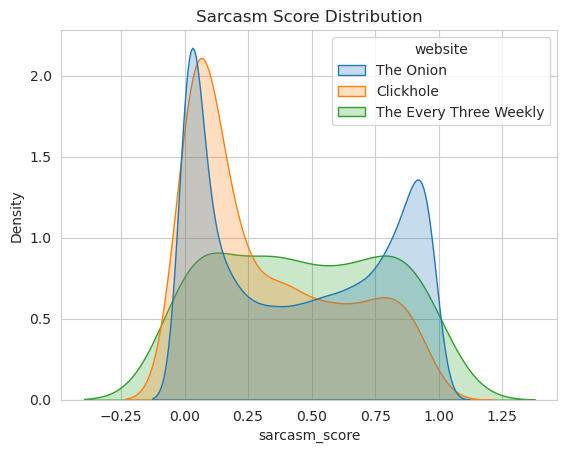

In [20]:
sns.kdeplot(data=df, x="sarcasm_score", hue="website", fill=True, common_norm=False)
plt.title("Sarcasm Score Distribution")
plt.show()